Поля:
- flag:   Была ли совершена покупка
- gender: Пол
- education: Образование
- house_val: Стоимость дома
- age: Возрастная группа
- online: Был ли опыт онлайн покупок
- customer_psy: Переменная, описывающая психологию потребителя в зависимости от района проживания (что бы это ни было)
- marriage: Семейный статус
- child: Есть ли дети
- occupation: Информация о карьере покупателя
- mortgage: Информация о кредите на жилье
- house_owner: В какой собственности дом
- region: Регион проживания
- car_prob: Вероятность того, что клиент купит новый автомобиль
- fam_income: Информация о семейном доходе клиента (A означает самый низкий, а L - самый высокий)


In [55]:
import pandas as pd
from pandas import DataFrame
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

CLUSTERS = [
    # (color, sign)
    ('lightgreen', 's'),
    ('orange', 'o'),
    ('lightblue', 'v'),
    ('fuchsia', '*'),
    ('black', 'd')
]
CENTROIDS = ('red', 'P')

VISUALISATION_PAIRS = [
    # Цена дома и покупательская способность
    (3, 13),
    # Образование и возраст
    (2, 4)
]

In [20]:
data = pd.read_csv('data.csv')

In [21]:
# Вывод информации о датасете
def data_analise(_data: DataFrame):
    _data.info()
    _data.describe()
    _data.nunique()
    feature_names = _data.columns.tolist()
    for column in feature_names:
        print(column)
        print(_data[column].value_counts(dropna=False))
        print()


data_analise(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   flag          40000 non-null  object
 1   gender        40000 non-null  object
 2   education     39259 non-null  object
 3   house_val     40000 non-null  int64 
 4   age           40000 non-null  object
 5   online        40000 non-null  object
 6   customer_psy  40000 non-null  object
 7   marriage      25973 non-null  object
 8   child         40000 non-null  object
 9   occupation    40000 non-null  object
 10  mortgage      40000 non-null  object
 11  house_owner   36623 non-null  object
 12  region        40000 non-null  object
 13  car_prob      40000 non-null  int64 
 14  fam_income    40000 non-null  object
dtypes: int64(2), object(13)
memory usage: 4.6+ MB
flag
Y    20000
N    20000
Name: flag, dtype: int64

gender
M    22019
F    16830
U     1151
Name: gender, dtype: int64

educa

In [22]:
# мапинги преобразования данных
Y_N_mapping = {
    'Y': 1,
    'N': 0
}

letter_mapping = lambda letter: (ord(letter) - ord('A') + 1) if letter != 'U' else 0

get_first_number = lambda value: int(value[0])
value_or_nan = lambda mapping, nan_value: (
    lambda value: mapping(value)
    if type(value) is str
    else nan_value
)

mapping = {
    'flag': Y_N_mapping,
    'gender': {
        'M': 2,
        'F': 1,
        'U': 0
    },
    # NaN приравнивается к коледжу, т.к. у большей части именно такое образование
    'education': value_or_nan(get_first_number, 2),
    'age': get_first_number,
    'online': Y_N_mapping,
    'customer_psy': letter_mapping,
    'marriage': value_or_nan(lambda value: {'Married': 2, 'Single': 0}[value], 1),
    'child': {
        **Y_N_mapping,
        '0': 0,
        'U': 2
    },
    'occupation': {
        'Professional': 1,
        'Sales/Service': 2,
        'Blue Collar': 3,
        'Retired': 4,
        'Others': 5,
        'Farm': 6,
    },
    'mortgage': get_first_number,
    'house_owner': value_or_nan(lambda value: {'Renter': 2, 'Owner': 1}[value], 0),
    'region': {
        'South': 1,
        'West': 2,
        'Midwest': 3,
        'Northeast': 4,
        'Rest': 5,
    },
    'fam_income': letter_mapping,
}

In [23]:
# Приведение датасета в необходимое состояние
for column, column_mapping in mapping.items():
    data[column] = data[column] \
        .map(column_mapping)

In [24]:
data_analise(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   flag          40000 non-null  int64
 1   gender        40000 non-null  int64
 2   education     40000 non-null  int64
 3   house_val     40000 non-null  int64
 4   age           40000 non-null  int64
 5   online        40000 non-null  int64
 6   customer_psy  40000 non-null  int64
 7   marriage      40000 non-null  int64
 8   child         40000 non-null  int64
 9   occupation    40000 non-null  int64
 10  mortgage      40000 non-null  int64
 11  house_owner   40000 non-null  int64
 12  region        40000 non-null  int64
 13  car_prob      40000 non-null  int64
 14  fam_income    40000 non-null  int64
dtypes: int64(15)
memory usage: 4.6 MB
flag
1    20000
0    20000
Name: flag, dtype: int64

gender
2    22019
1    16830
0     1151
Name: gender, dtype: int64

education
2    12141
3     9267
1 

In [25]:
data.describe()

,flag,gender,education,house_val,age,online,customer_psy,marriage,child,occupation,mortgage,house_owner,region,car_prob,fam_income
count,40000.000000,40000.000000,40000.000000,4.000000e+04,40000.000000,40000.000000,40000.00000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,0.500000,1.521700,2.114375,3.072138e+05,4.113800,0.682975,4.64675,1.395225,0.876700,2.192525,1.387525,1.100350,2.191500,3.491150,5.776450
std,0.500006,0.554154,1.189844,4.222146e+05,1.932742,0.465323,2.48907,0.702235,0.731102,1.232456,0.710501,0.509054,1.156616,2.577719,2.720471
min,0.000000,0.000000,0.000000,0.000000e+00,1.000000,0.000000,0.00000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000,8.065725e+04,3.000000,0.000000,3.00000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000
50%,0.500000,2.000000,2.000000,2.148720e+05,4.000000,1.000000,5.00000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,3.000000,5.000000
75%,1.000000,2.000000,3.000000,3.937620e+05,6.000000,1.000000,6.00000,2.000000,1.000000,3.000000,2.000000,1.000000,3.000000,5.000000,7.000000
max,1.000000,2.000000,4.000000,9.999999e+06,7.000000,1.000000,10.00000,2.000000,2.000000,6.000000,3.000000,2.000000,5.000000,9.000000,12.000000


In [50]:
def k_means(_data: DataFrame, n_clusters, visualisation_pairs: (int, int)):
    km = KMeans(
        n_clusters=n_clusters,
        init='random',
        n_init=10,
        random_state=0
    )
    y_km = km.fit_predict(_data)

    get_by_cluster = lambda cluster, column: [
        row[column]
        for index, row in _data.iterrows()
        if y_km[index] == cluster
    ]

    def visualisation(x: int, y: int):
        for cluster in range(n_clusters):
            color, sign = CLUSTERS[cluster]
            plt.scatter(
                get_by_cluster(cluster, x),
                get_by_cluster(cluster, y),
                s=50,
                marker=sign,
                c=color,
                label=f'Кластер {cluster + 1}'
            )
        plt.scatter(
            km.cluster_centers_[:, x],
            km.cluster_centers_[:, y],
            s=250,
            marker=CENTROIDS[1],
            c=CENTROIDS[0],
            label='Центроиды'
        )
        plt.legend()
        plt.grid()
        plt.show()

    [visualisation(*pair) for pair in visualisation_pairs]

    return y_km

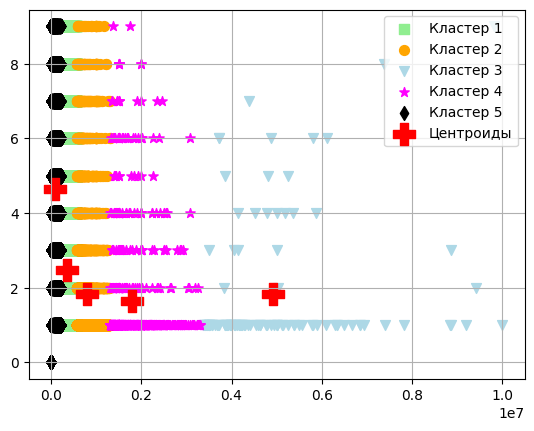

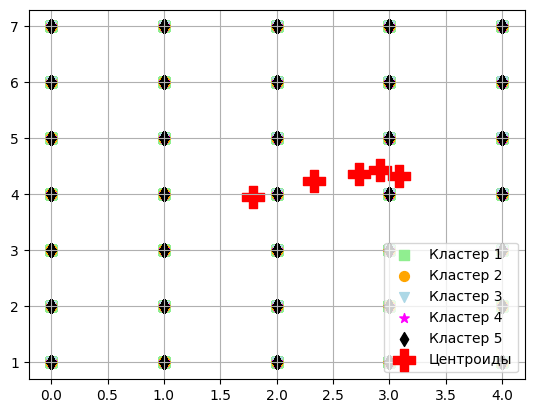

array([1, 4, 4, ..., 4, 0, 1], dtype=int32)

In [57]:
k_means(
    data,
    5,
    VISUALISATION_PAIRS
)

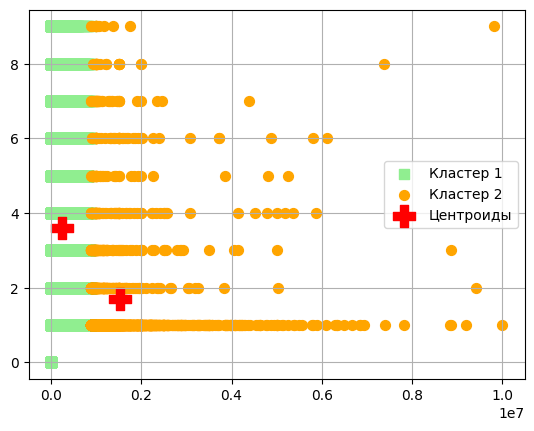

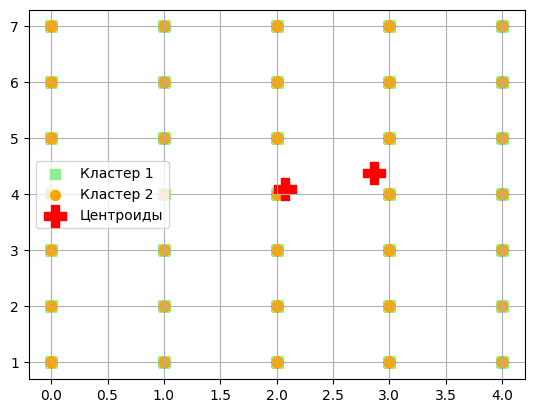

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [58]:
k_means(
    data,
    2,
    VISUALISATION_PAIRS
)